In [ ]:
# Slice the raw signals from GENEActiv device based on task start and end timestamp
# tremor score 
# standing and sitting tasks

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import tsfresh
from tsfresh.feature_extraction import extract_features, MinimalFCParameters, EfficientFCParameters
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
direc = "E:\\WS4PD_data"
os.chdir(direc)
save_path = os.path.join(direc, "Figures", "Data_exploration", "GENEActiv_tremor")
# load data
demogra_data = pd.read_csv("Demographics_data.csv")
task_score = pd.read_csv("Task_scores_part_I.csv")

In [3]:
print(demogra_data.shape)
demogra_data.head()

(28, 47)


,ROW_ID,ROW_VERSION,subject_id,cohort,gender,birth_year,dominant_hand,upper_limb_length,upper_arm_length,lower_arm_length,...,recording_end,timezone,updrs_time,updrs_score_p1,updrs_score_p2,updrs_score_p3,updrs_score_p4,h_and_y_score,updrs_second_visit_time,updrs_second_visit_score_p3
0,1,1,7_NYC,PD,Male,1956,Right,NaN,33,29,...,14:54:00,Eastern Daylight Time (GMT -4),12:07:00,24,22,55,8,NaN,11:56:00,61
1,2,1,2_NYC,PD,Male,1959,Right,NaN,32,26,...,14:44:00,Eastern Standard Time (GMT -5),12:39:00,13,14,10,13,2.0,9:50:00,22
2,3,1,3_NYC,PD,Male,1969,Right,NaN,32,29,...,14:14:00,Eastern Daylight Time (GMT -4),12:33:00,12,16,16,4,2.0,10:15:00,35
3,4,1,4_NYC,PD,Male,1952,Right,NaN,36,28,...,13:34:00,Eastern Daylight Time (GMT -4),13:44:00,0,7,19,0,2.0,9:40:00,36
4,5,1,5_NYC,PD,Male,1960,Right,NaN,25,28,...,13:02:00,Eastern Daylight Time (GMT -4),12:00:00,12,10,12,11,2.0,8:24:00,37


In [4]:
print(task_score.shape)
task_score.head()

(62199, 13)


,ROW_ID,ROW_VERSION,subject_id,visit,session,task_id,task_code,repetition,timestamp_start,timestamp_end,phenotype,body_segment,score
0,1,1,3_BOS,1,1,1,stndg,1,1423568629,1423568661,tremor,RightUpperLimb,0
1,2,1,3_BOS,1,1,1,stndg,1,1423568629,1423568661,tremor,LeftUpperLimb,0
2,3,1,3_BOS,1,1,1,stndg,1,1423568629,1423568661,tremor,LowerLimbs,0
3,4,1,3_BOS,1,1,1,stndg,1,1423568629,1423568661,dyskinesia,RightUpperLimb,Yes
4,5,1,3_BOS,1,1,1,stndg,1,1423568629,1423568661,dyskinesia,LeftUpperLimb,Yes


In [5]:
# Check data type and missing timestamp
phenotype = 'tremor'
# task_code = ['stndg', 'sittg']
task_code = ['stndg', 'sittg']
device = 'GENEActiv'
visit = 1
sample_rate = 50
dt = 1/sample_rate
subject_ids = task_score.subject_id.unique()
summary = pd.DataFrame()
for sb in subject_ids:
    sensor_path = os.path.join(direc, device, sb, 'rawdata_day'+str(visit)+'.txt')
    sensor_data = pd.read_table(sensor_path)
    is_float = sensor_data.dtypes == 'float'
    interval = np.round_(np.diff(sensor_data.timestamp),2)
    is_dt = interval == (1/sample_rate)
    missing_ts = [i for i, val in enumerate(~is_dt) if val]  
    summary_sb = pd.DataFrame(data= {'subject_id': sb, 'timestamp': is_float[0], 'GENEActiv_X': is_float[1],
            'GENEActiv_Y': is_float[2], 'GENEActiv_Z': is_float[3],
             'GENEActiv_Magnitude': is_float[4], 'missing_timestamp':[[missing_ts]]})
    summary = pd.concat([summary,summary_sb])

In [6]:
summary

,subject_id,timestamp,GENEActiv_X,GENEActiv_Y,GENEActiv_Z,GENEActiv_Magnitude,missing_timestamp
0,3_BOS,True,True,True,True,True,[[]]
0,4_BOS,True,True,True,True,True,[[]]
0,5_BOS,True,True,True,True,True,[[]]
0,6_BOS,True,True,True,True,True,[[]]
0,7_BOS,True,True,True,True,True,[[]]
0,8_BOS,True,True,True,True,True,[[]]
0,9_BOS,True,True,True,True,True,[[]]
0,10_BOS,True,True,True,True,True,[[]]
0,11_BOS,True,True,True,True,True,[[]]
0,12_BOS,True,True,True,True,True,[[]]


In [7]:
# subjects in the training dataset
# train:test = 0.67:0.33
# sb_train = ['11_NYC', '6_BOS', '8_BOS', '2_NYC', '7_NYC', '5_BOS', '11_BOS', '15_BOS', '4_NYC',
#                 '12_NYC', '6_NYC', '3_BOS', '14_BOS', '18_BOS', '9_NYC', '4_BOS', '9_BOS', '16_BOS']

# train:test = 0.75:0.25
sb_train = ['8_BOS', '11_NYC', '2_NYC', '9_NYC', '3_BOS', '8_NYC', '7_NYC', '18_BOS', '15_BOS',
           '4_NYC', '12_NYC', '9_BOS', '6_NYC', '6_BOS', '16_BOS', '5_BOS', '14_BOS', '4_BOS',
           '11_BOS', '10_BOS', '17_BOS']

## Dataset construction

In [8]:
df = pd.DataFrame()
for sb in subject_ids:
# for sb in sb_train:
    geneactive_hand = demogra_data.geneactive_hand.loc[demogra_data.subject_id == sb].values[0]
    body_segment = geneactive_hand+'UpperLimb'
    sensor_path = os.path.join(direc, device, sb, 'rawdata_day'+str(visit)+'.txt')
    sensor_data = pd.read_table(sensor_path)
    is_trialtype = (task_score.subject_id == sb) & (task_score.visit == visit) &\
    (task_score.body_segment == body_segment) & (task_score.phenotype == phenotype) &\
     (np.isin(task_score.task_code,task_code))
    trial_idx = [i for i, val in enumerate(is_trialtype) if val]
    for trial in trial_idx:
        score = int(task_score['score'].values[trial])
        session = task_score['session'].values[trial]
        task_code = task_score['task_code'].values[trial]
        repetition = task_score['repetition'].values[trial]
        ts_start = task_score['timestamp_start'].values[trial]
        ts_end = task_score['timestamp_end'].values[trial]
        is_ts = (sensor_data.timestamp.values >= ts_start) & (sensor_data.timestamp.values <= ts_end)
        x = sensor_data['GENEActiv_X'].loc[is_ts].values
        y = sensor_data['GENEActiv_Y'].loc[is_ts].values
        z = sensor_data['GENEActiv_Z'].loc[is_ts].values
        mag = sensor_data['GENEActiv_Magnitude'].loc[is_ts].values
        df_trial = pd.DataFrame(data= {'subject_id': sb, 'visit': visit, 'session': session,
                                       'task_code': task_code, 'repetition': repetition,
                                       'body_segment':body_segment, 'phenotype':phenotype,
                                       'score':score, 'GENEActiv_X': [x], 'GENEActiv_Y': [y],
                                       'GENEActiv_Z': [z], 'GENEActiv_Magnitude': [mag]})
        df = pd.concat([df,df_trial])
df.reset_index(drop=True)

,subject_id,visit,session,task_code,repetition,body_segment,phenotype,score,GENEActiv_X,GENEActiv_Y,GENEActiv_Z,GENEActiv_Magnitude
0,8_BOS,1,1,stndg,1,RightUpperLimb,tremor,1,"[-4.71991, -4.20254, -3.31311, -3.23072, -3.32...","[9.43729, 9.34014, 9.1789, 9.41105, 9.352, 9.0...","[-1.23089, -0.74845, -0.56149, -0.54361, -0.74...","[10.62333, 10.26936, 9.77468, 9.96499, 9.95443..."
1,8_BOS,1,1,sittg,1,RightUpperLimb,tremor,3,"[-7.61445, -7.57274, -7.68637, -7.55867, -7.50...","[-1.62559, -1.72919, -1.50066, -1.57692, -1.55...","[-6.18311, -6.11621, -5.96305, -5.98292, -6.34...","[9.94249, 9.88658, 9.84328, 9.76809, 9.95234, ..."
2,8_BOS,1,2,stndg,1,RightUpperLimb,tremor,3,"[-2.93665, -3.28559, -3.26178, -3.22266, -3.14...","[9.25725, 9.19076, 8.98561, 9.16132, 9.14433, ...","[-0.01665, -0.09939, 0.07103, 0.1589, 0.26283,...","[9.71189, 9.76089, 9.55957, 9.71291, 9.67329, ..."
3,8_BOS,1,2,sittg,1,RightUpperLimb,tremor,3,"[-7.59079, -7.20316, -6.88716, -7.11252, -7.56...","[-1.55564, -1.36425, -1.11007, -1.24034, -1.30...","[-6.68787, -6.48554, -6.34241, -6.63177, -6.64...","[10.23561, 9.7882, 9.42822, 9.80341, 10.15597,..."
4,8_BOS,1,3,stndg,1,RightUpperLimb,tremor,1,"[-3.34043, -3.60371, -3.46685, -3.40617, -3.63...","[8.75879, 8.8715, 8.94794, 8.96229, 9.03435, 9...","[-0.23401, -0.33216, -0.51117, -0.56758, -0.36...","[9.37708, 9.58126, 9.60968, 9.60451, 9.74517, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
142,17_BOS,1,2,sittg,1,LeftUpperLimb,tremor,0,"[-8.32363, -8.04205, -8.35573, -8.82122, -9.82...","[-1.58112, -1.80767, -1.85025, -2.14576, -2.29...","[-4.09614, -3.91306, -3.87113, -3.37754, -2.24...","[9.41069, 9.12437, 9.39294, 9.68638, 10.33238,..."
143,17_BOS,1,3,sittg,1,LeftUpperLimb,tremor,0,"[-6.03311, -6.36567, -6.40561, -6.43642, -6.40...","[-4.51587, -4.46578, -4.11537, -4.06147, -3.71...","[-6.18264, -6.28619, -6.36665, -6.48351, -6.49...","[9.74765, 9.99906, 9.92484, 9.99795, 9.84734, ..."
144,17_BOS,1,4,sittg,1,LeftUpperLimb,tremor,0,"[-1.87462, -1.70066, 0.80869, 1.737, 2.25768, ...","[-3.93165, -3.7401, -3.65169, -3.3977, -4.3287...","[-10.17913, -8.95162, -8.16418, -8.19072, -9.1...","[11.07189, 9.84947, 8.98012, 9.03601, 10.33785..."
145,17_BOS,1,5,sittg,1,LeftUpperLimb,tremor,0,"[-5.48754, -5.37351, -5.27985, -5.31555, -4.83...","[-3.18103, -3.13757, -3.50082, -3.12604, -3.02...","[-7.27985, -7.42547, -7.53746, -7.56792, -7.52...","[9.65548, 9.68796, 9.84611, 9.76221, 9.44459, ..."


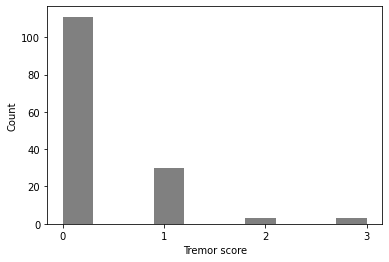

In [9]:
# score distribution
hist, bin_edges = np.histogram(df.score)
fig, ax = plt.subplots()
ax.hist(df.score, histtype='bar', color = 'grey')
ax.set_xlabel('Tremor score')
ax.set_ylabel('Count')
ax.set_xticks([0,1,2,3])
# save figure
plt.savefig(os.path.join(save_path,"Tremor_score_distribution"))

In [10]:
counts, bins = np.histogram(df.score, bins = range(6))
counts

array([111,  30,   3,   3,   0], dtype=int64)

In [11]:
# Merge score 2 and 3
df['score'].loc[df['score']==3] = 2
counts, bins = np.histogram(df.score, bins = range(6))
counts

array([111,  30,   6,   0,   0], dtype=int64)

In [12]:
# Upsampling by copying minority class instances
from sklearn.utils import resample
upsampled_df = pd.DataFrame()
counts, bins = np.histogram(df.score, bins = range(5))
upsample_size = round(max(counts)/2)
for c,s in zip(counts[0:3],range(3)):
    if c == max(counts):
        upsample = df.loc[df['score']==s]
    else:
        upsample = resample(df.loc[df['score']==s],
                 replace=True,
                 n_samples=upsample_size,
                 random_state=42)
    upsampled_df = pd.concat([upsampled_df, upsample])
    
print(upsampled_df.shape)
upsampled_df.reset_index(drop=True)
# Try other upsmapling methods:
# from imblearn.over_sampling import SMOTE


(223, 12)


,subject_id,visit,session,task_code,repetition,body_segment,phenotype,score,GENEActiv_X,GENEActiv_Y,GENEActiv_Z,GENEActiv_Magnitude
0,8_BOS,1,3,sittg,1,RightUpperLimb,tremor,0,"[-7.7522, -7.56672, -7.89022, -8.75062, -8.580...","[-0.75242, -0.7359, -1.07346, -1.03954, -0.821...","[-6.19821, -5.447, -5.46752, -5.72031, -5.9324...","[9.95392, 9.35236, 9.65928, 10.506, 10.46413, ..."
1,8_BOS,1,4,sittg,1,RightUpperLimb,tremor,0,"[-9.29687, -9.52726, -8.80517, -6.95433, -6.15...","[1.29175, 1.02939, 1.03369, 0.85684, 0.64538, ...","[-5.33561, -5.26686, -5.13845, -4.33353, -3.60...","[10.79672, 10.93473, 10.24711, 8.23871, 7.1628..."
2,8_BOS,1,5,sittg,1,RightUpperLimb,tremor,0,"[-7.78927, -7.85905, -7.92057, -7.87386, -7.93...","[-1.32121, -1.3184, -1.17162, -1.0311, -0.9196...","[-5.81318, -5.95157, -5.97513, -5.90303, -5.57...","[9.80874, 9.94606, 9.99051, 9.89478, 9.7399, 9..."
3,8_BOS,1,6,sittg,1,RightUpperLimb,tremor,0,"[-8.76892, -8.49104, -8.72139, -9.22274, -9.57...","[-0.09152, 0.42593, 0.12325, -0.35457, 0.07951...","[-4.50195, -4.26281, -4.12803, -4.07038, -4.35...","[9.85748, 9.51056, 9.64979, 10.08725, 10.51602..."
4,11_NYC,1,1,sittg,1,RightUpperLimb,tremor,0,"[-2.00742, -2.16237, -2.04567, -1.54161, -1.89...","[-4.38848, -4.27276, -4.23353, -3.92364, -3.80...","[-8.49158, -8.76028, -9.26042, -8.72203, -8.68...","[9.76705, 9.98373, 10.38571, 9.68738, 9.66868,..."
...,...,...,...,...,...,...,...,...,...,...,...,...
218,8_BOS,1,2,stndg,1,RightUpperLimb,tremor,2,"[-2.93665, -3.28559, -3.26178, -3.22266, -3.14...","[9.25725, 9.19076, 8.98561, 9.16132, 9.14433, ...","[-0.01665, -0.09939, 0.07103, 0.1589, 0.26283,...","[9.71189, 9.76089, 9.55957, 9.71291, 9.67329, ..."
219,8_BOS,1,2,stndg,1,RightUpperLimb,tremor,2,"[-2.93665, -3.28559, -3.26178, -3.22266, -3.14...","[9.25725, 9.19076, 8.98561, 9.16132, 9.14433, ...","[-0.01665, -0.09939, 0.07103, 0.1589, 0.26283,...","[9.71189, 9.76089, 9.55957, 9.71291, 9.67329, ..."
220,8_BOS,1,1,sittg,1,RightUpperLimb,tremor,2,"[-7.61445, -7.57274, -7.68637, -7.55867, -7.50...","[-1.62559, -1.72919, -1.50066, -1.57692, -1.55...","[-6.18311, -6.11621, -5.96305, -5.98292, -6.34...","[9.94249, 9.88658, 9.84328, 9.76809, 9.95234, ..."
221,8_BOS,1,2,stndg,1,RightUpperLimb,tremor,2,"[-2.93665, -3.28559, -3.26178, -3.22266, -3.14...","[9.25725, 9.19076, 8.98561, 9.16132, 9.14433, ...","[-0.01665, -0.09939, 0.07103, 0.1589, 0.26283,...","[9.71189, 9.76089, 9.55957, 9.71291, 9.67329, ..."


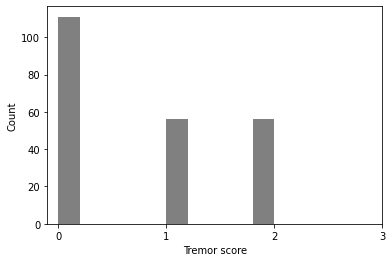

In [13]:
# score distribution after upsampling
fig, ax = plt.subplots()
ax.hist(upsampled_df.score, histtype='bar', color = 'grey')
ax.set_xlabel('Tremor score')
ax.set_ylabel('Count')
ax.set_xticks([0,1,2,3])
# save figure
plt.savefig(os.path.join(save_path,"Tremor_score_distribution_upsampled"))

In [14]:
# Construct data for tsfresh
# each trial has a different id
df_tsfresh = pd.DataFrame()
for trial in range(len(upsampled_df)):
    x = upsampled_df.GENEActiv_X.iloc[trial]
    y = upsampled_df.GENEActiv_Y.iloc[trial]
    z = upsampled_df.GENEActiv_Z.iloc[trial]
    t = np.round_([item * dt for item in range(len(x))],2)
    df_trial = pd.DataFrame(data = {'id':trial, 'time':t, 'x': x, 'y': y, 'z': z})
    df_tsfresh = pd.concat([df_tsfresh,df_trial])

In [15]:
print(df_tsfresh.shape)

(373530, 5)


## Feature extraction

In [16]:
# extract comprehensive features (default)
extracted_features = extract_features(df_tsfresh, column_id="id", column_sort="time")

Feature Extraction: 100%|██████████| 20/20 [15:19<00:00, 45.99s/it]


In [17]:
print(extracted_features.shape)
extracted_features.head()

(223, 2262)


variable,x__abs_energy,x__absolute_sum_of_changes,"x__agg_autocorrelation__f_agg_""mean""__maxlag_40","x__agg_autocorrelation__f_agg_""median""__maxlag_40","x__agg_autocorrelation__f_agg_""var""__maxlag_40","x__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","x__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","x__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","x__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","x__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,z__symmetry_looking__r_0.9,z__symmetry_looking__r_0.9500000000000001,z__time_reversal_asymmetry_statistic__lag_1,z__time_reversal_asymmetry_statistic__lag_2,z__time_reversal_asymmetry_statistic__lag_3,z__value_count__value_-1,z__value_count__value_0,z__value_count__value_1,z__variance,z__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
0,108607.603277,111.69423,0.669606,0.664863,0.001504,-7.900183,-0.752309,-0.002799,0.000195,-7.783954,...,1.0,1.0,0.067775,0.112839,0.181089,0.0,0.0,0.0,0.071277,0.0
1,113038.059780,143.65700,0.214613,0.210303,0.011074,-7.837505,-0.480257,-0.003489,0.000499,-7.667395,...,1.0,1.0,0.018659,-0.004050,-0.079794,0.0,0.0,0.0,0.061167,0.0
2,127418.776278,131.13415,0.393075,0.414385,0.014481,-8.606173,-0.482380,-0.002354,0.000340,-8.429707,...,1.0,1.0,0.128090,0.260262,0.362356,0.0,0.0,0.0,0.079822,0.0
3,128132.761639,130.69424,0.571686,0.568766,0.001985,-8.349297,-0.832430,-0.002481,0.000127,-8.250694,...,1.0,1.0,0.009844,0.009933,0.019294,0.0,0.0,0.0,0.049609,0.0
4,4632.465151,130.47247,0.805300,0.802514,0.001243,-1.821136,0.911691,0.003411,0.000118,-1.751196,...,1.0,1.0,-0.034429,0.045141,0.035016,0.0,0.0,0.0,0.010130,0.0


In [18]:
score = upsampled_df.score.reset_index(drop=True)
print(len(score))

223


## Feature selection

In [19]:
# Removing features with nan
extracted_features2 = extracted_features.dropna(axis=1)
print(extracted_features2.shape)

(223, 2247)


In [20]:
# Removing features with zero variance
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold()
extracted_features3 = sel.fit_transform(extracted_features2)
filter3 = sel.get_support()
feature_names2 = extracted_features2.columns
feature_names3 = feature_names2[filter3]
extracted_features3 = pd.DataFrame(extracted_features3, columns=feature_names3)
print(extracted_features3.shape)

(223, 2134)


In [21]:
# Univariate Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from numpy import set_printoptions
test = SelectKBest(score_func=f_classif, k=30)
extracted_features4 = test.fit_transform(extracted_features3, score)


C:\Users\Yiting\Anaconda3\envs\ws4pd\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [  66  774 1486] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\Yiting\Anaconda3\envs\ws4pd\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


In [22]:
extracted_features4.shape

(223, 30)

In [23]:
filter4 = test.get_support()
feature_names4 = feature_names3[filter4]
extracted_features4 = pd.DataFrame(extracted_features4, columns=feature_names4)


In [24]:
feature_names4

Index(['x__absolute_sum_of_changes',
       'x__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"rvalue"',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8',
       'x__mean_abs_change', 'y__absolute_sum_of_changes',
       'y__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"rvalue"',
       'y__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0',
       'y__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.2',
       'y__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.4',
       'y__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6',
       'y__mean_abs_change', 'y__partial_autocorrelation__lag_9',
       'z__absolute_sum_of_changes',
       'z__

In [ ]:
# for i in range(30):
#     feature_name = feature_names4[i]
#     x = extracted_features4[feature_name]
#     y = score
#     fig, ax = plt.subplots()
#     ax.scatter(x,y,facecolors='none', edgecolors='b')
#     ax.set_xlabel(feature_name)
#     ax.set_ylabel('Tremor score')
#     ax.set_yticks([0,1,2])
#     ax.set_yticklabels(['0','1','2/3'])
#     # save figure
#     file_name = 'ranked_feature_'+ str(i)
#     plt.savefig(os.path.join(save_path,'SelectKBest','feature_vs_score',file_name))

In [25]:
corr_summary = np.zeros((30,30))
for i in range(30):
    feature_name_x = feature_names4[i]
    x = extracted_features4[feature_name_x]
    for j in range(30):
        feature_name_y = feature_names4[j]
        y = extracted_features4[feature_name_y]
#         fig, ax = plt.subplots()
#         ax.scatter(x,y,facecolors='none', edgecolors='b')
#         ax.set_xlabel(feature_name_x)
#         ax.set_ylabel(feature_name_y)
        corr, _ = stats.pearsonr(x, y)
#         ax.set_title(['Pearsons correlation: '+ str(round(corr,3))])
        corr_summary[i,j] = corr
        # save figure
#         file_name = 'features_'+ str(i)+ '_'+str(j)
#         plt.savefig(os.path.join(save_path,'SelectKBest','feature_vs_feature',file_name))

In [26]:
plt.close

<function matplotlib.pyplot.close(fig=None)>

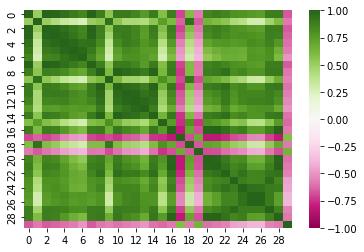

In [27]:
ax = sns.heatmap(corr_summary, vmin=-1, vmax=1, cmap="PiYG")
# save figure
# plt.savefig(os.path.join(save_path,'SelectKBest','feature_vs_feature','corr_heatmap'))

In [28]:
X=extracted_features4.values
X.shape

(223, 30)

In [29]:
# PCA
from sklearn.decomposition import PCA
X=extracted_features4.values
pca = PCA(n_components=10)
fit = pca.fit(X)

In [30]:
# Cumulative explained variance
np.cumsum(fit.explained_variance_ratio_)

array([0.94294311, 0.99155173, 0.99920195, 0.9998346 , 0.99999914,
       0.99999952, 0.99999971, 0.99999987, 0.99999993, 0.99999995])

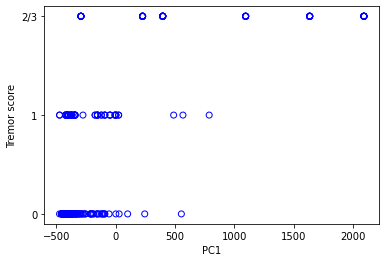

In [32]:
# Use PC1 as a feature to train models? 
X_new = pca.fit_transform(X)
PC1 = X_new[:,0]
x = PC1
y = score
fig, ax = plt.subplots()
ax.scatter(x,y,facecolors='none', edgecolors='b')
ax.set_xlabel('PC1')
ax.set_ylabel('Tremor score')
ax.set_yticks([0,1,2])
ax.set_yticklabels(['0','1','2/3'])
# save figure
file_name = 'PC1'
plt.savefig(os.path.join(save_path,'Train_dataset','SelectKBest','feature_vs_score',file_name))

In [33]:
# What waveform features contribute to PC1?
Y = fit.components_
indices = np.argsort(Y[0])[::-1] # sorting in a descending order
feature_names4[indices]

Index(['z__absolute_sum_of_changes', 'x__absolute_sum_of_changes',
       'y__absolute_sum_of_changes', 'z__cid_ce__normalize_False',
       'z__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.0',
       'z__change_quantiles__f_agg_"var"__isabs_False__qh_1.0__ql_0.2',
       'z__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0',
       'z__mean_abs_change',
       'z__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8',
       'z__change_quantiles__f_agg_"mean"__isabs_True__qh_0.4__ql_0.0',
       'z__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.2',
       'z__change_quantiles__f_agg_"var"__isabs_True__qh_1.0__ql_0.4',
       'z__agg_linear_trend__f_agg_"var"__chunk_len_10__attr_"rvalue"',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.8',
       'x__mean_abs_change',
       'x__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.0',
       'y__agg_linear_trend__f_agg_"var"__chunk_len_5__attr_"rvalue"',
       'x__agg_line

In [ ]:
# tsfresh- univariante tests
impute(extracted_features)
features_selected = select_features(extracted_features, score, ml_task = 'classification')

In [ ]:
print(features_selected.shape)
features_selected.head()

In [ ]:
list(features_selected.columns)

In [ ]:
relevance_df = tsfresh.feature_selection.relevance.calculate_relevance_table(extracted_features, score)

In [ ]:
relevance_df

In [ ]:
relevant_df = relevance_df.loc[relevance_df['relevant']==True]

In [ ]:
sorted_relevant_df = relevant_df.sort_values(by=['p_value'])

In [ ]:
sorted_relevant_df.feature.iloc[0]

In [ ]:
# plot

In [ ]:
'ranked_feature_'+ str(i)

In [ ]:
for i in range(30):
    feature_name = sorted_relevant_df.feature.iloc[i]
    x = extracted_features[feature_name]
    y = score
    fig, ax = plt.subplots()
    ax.scatter(x,y,facecolors='none', edgecolors='b')
    ax.set_xlabel(feature_name)
    ax.set_ylabel('Tremor score')
    ax.set_yticks([0,1,2])
    # save figure
    file_name = 'ranked_feature_'+ str(i)
    plt.savefig(os.path.join(save_path,file_name))

In [ ]:
corr_summary = np.zeros((50,50))
for i in range(50):
    feature_name_x = sorted_relevant_df.feature.iloc[i]
    x = extracted_features[feature_name_x]
    for j in range(50):
        feature_name_y = sorted_relevant_df.feature.iloc[j]
        y = extracted_features[feature_name_y]
#         fig, ax = plt.subplots()
#         ax.scatter(x,y,facecolors='none', edgecolors='b')
#         ax.set_xlabel(feature_name_x)
#         ax.set_ylabel(feature_name_y)
        corr, _ = stats.pearsonr(x, y)
#         ax.set_title(['Pearsons correlation: '+ str(round(corr,3))])
        corr_summary[i,j] = corr
#         # save figure
#         file_name = 'features_'+ str(i)+ '_'+str(j)
#         plt.savefig(os.path.join(save_path,file_name))

In [ ]:
corr_summary

In [ ]:

ax = sns.heatmap(corr_summary, vmin=-1, vmax=1, cmap="PiYG")
# save figure
plt.savefig(os.path.join(save_path,'corr_heatmap'))

In [ ]:
x = extracted_features['x__approximate_entropy__m_2__r_0.5']
y = score
plt.scatter(x,y)

In [ ]:
x = extracted_features['x__approximate_entropy__m_2__r_0.5']
y = extracted_features['x__approximate_entropy__m_2__r_0.9']
plt.scatter(x,y)

In [ ]:
p_value = significance_tests.target_real_feature_real_test(extracted_features.y__number_cwt_peaks__n_1, score)
p_value

In [ ]:
p_value

In [ ]:
# significant test
p_value = select_features.significance_tests.target_real_feature_real_test(extracted_features.x__number_peaks__n_5, score)
p_values


In [ ]:
# extract efficient features
efficient_features = extract_features(df_tsfresh, column_id="id", column_sort="time",
                                      default_fc_parameters=EfficientFCParameters())
# select efficient features 
impute(efficient_features)
selected_features = select_features(efficient_features, score)